# Classes and variables

In [1]:
from birdclassification.preprocessing.filtering import filter_recordings_30
from torch.utils.data import DataLoader
import torch
from sklearn.model_selection import train_test_split
from training.dataset import Recordings30
from birdclassification.visualization.plots import plot_torch_spectrogram
from training.cnn_training_torch.CNN_model import CNNNetwork
from torchsummary import summary

In [2]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
    
SEED = 123
RECORDINGS_DIR = '/media/jacek/E753-A120/recordings_30/'
NOISES_DIR = '/aaa/'

SAMPLE_RATE = 32000
NUM_SAMPLES = SAMPLE_RATE * 1
BATCH_SIZE = 64

/home/jacek/PycharmProjects/Bird-classification-model/venv/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# Prepare dataset and dataloaders

In [3]:
df = filter_recordings_30("../../data/xeno_canto_recordings.csv", "../../data/bird-list-extended.csv", )

train_df, test_val_df = train_test_split(df, stratify=df['Latin name'], test_size=0.2, random_state = SEED)
val_df, test_df = train_test_split(test_val_df, stratify=test_val_df['Latin name'], test_size=0.5, random_state = SEED)

train_ds = Recordings30(train_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR, sample_rate=SAMPLE_RATE, device = DEVICE)
val_ds = Recordings30(val_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR, device = DEVICE)
test_ds = Recordings30(test_df, recording_dir=RECORDINGS_DIR, noises_dir=NOISES_DIR, device = DEVICE)

train_dl  = DataLoader(train_ds, batch_size= BATCH_SIZE)
val_dl  = DataLoader(val_ds, batch_size= BATCH_SIZE)
test_dl  = DataLoader(test_ds, batch_size= BATCH_SIZE)

/home/jacek/PycharmProjects/Bird-classification-model/birdclassification/preprocessing/filtering.py:48: DtypeWarning: Columns (10,39,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  recordings = pd.read_csv(filepath_recordings)


In [4]:
df

,index,Unnamed: 0,id,gen,sp,ssp,group,en,rec,cnt,...,smp,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Latin name
0,5,5,815762,Cygnus,olor,NaN,birds,Mute Swan,Frédéric Cazaban,France,...,44100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cygnus olor
1,6,6,808540,Cygnus,olor,NaN,birds,Mute Swan,Juha Saari,Finland,...,44100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cygnus olor
2,7,7,805048,Cygnus,olor,NaN,birds,Mute Swan,Magnus Hellström,Sweden,...,44100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cygnus olor
3,8,8,804791,Cygnus,olor,NaN,birds,Mute Swan,Uku Paal,Estonia,...,44100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cygnus olor
4,9,9,797609,Cygnus,olor,NaN,birds,Mute Swan,Jorge Leitão,Germany,...,44100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cygnus olor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41205,296788,296788,108758,Columba,livia,NaN,birds,Rock Dove,Albert Lastukhin,Venezuela,...,44100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Columba livia
41206,296789,296789,58488,Columba,livia,NaN,birds,Rock Dove,Mike Nelson,United States,...,44100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Columba livia
41207,296790,296790,6924,Columba,livia,domestica,birds,Rock Dove,Glauco Alves Pereira,Brazil,...,22050.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Columba livia
41208,296791,296791,387816,Columba,livia,NaN,birds,Rock Dove,johannes buhl,Germany,...,44100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Columba livia


torch.Size([1, 422848])
torch.Size([1, 422848])
torch.Size([1, 96000])
(64, 251)
Function: 'forward', execution time: 1.1827356815338135


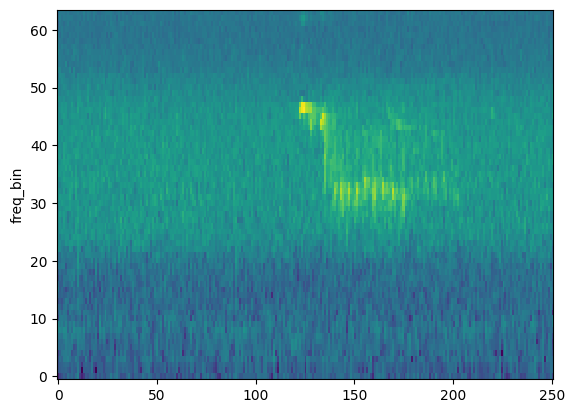

In [4]:
from torchaudio import transforms
from birdclassification.visualization.plots import plot_waveform
audio, label = train_ds[0]
plot_torch_spectrogram(audio)

In [5]:
cnn = CNNNetwork().to(DEVICE)
summary(cnn, (1, 64, 251)) 

input torch.Size([2, 1, 64, 251])
conv1 torch.Size([2, 16, 33, 126])
conv2 torch.Size([2, 32, 17, 64])
conv3 torch.Size([2, 64, 9, 33])
conv4 torch.Size([2, 128, 5, 17])
flatten torch.Size([2, 10880])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 66, 253]             160
              ReLU-2          [-1, 16, 66, 253]               0
         MaxPool2d-3          [-1, 16, 33, 126]               0
            Conv2d-4          [-1, 32, 35, 128]           4,640
              ReLU-5          [-1, 32, 35, 128]               0
         MaxPool2d-6           [-1, 32, 17, 64]               0
            Conv2d-7           [-1, 64, 19, 66]          18,496
              ReLU-8           [-1, 64, 19, 66]               0
         MaxPool2d-9            [-1, 64, 9, 33]               0
           Conv2d-10          [-1, 128, 11, 35]          73,856
             ReLU-11          

In [6]:
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In [7]:
loss_fn = torch.nn.CrossEntropyLoss()

In [8]:
from datetime import datetime
import sys
from training.training_utils import train_one_epoch
from torch.utils.tensorboard import SummaryWriter
from training.validation_metrics import calculate_metric
from sklearn.metrics import f1_score

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'logs/fashion_trainer_{timestamp}')
epoch_number = 0

EPOCHS = 7

best_vloss = sys.float_info.max

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    # Make sure gradient tracking is on, and do a pass over the data
    cnn.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, train_dl, optimizer, loss_fn, cnn)
    
    # Set the model to evaluation mode, disabling dropout and using population 
    # statistics for batch normalization.
    cnn.eval()
    running_vloss = 0.0

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_dl):
            vinputs, vlabels = vdata
            voutputs = cnn(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
    
    avg_vloss = running_vloss / (i + 1)
    print("#############################################################")
    print("Epoch results:")
    print(f'Loss train {avg_loss} valid loss: {avg_vloss}')
    validation_f1_score = calculate_metric(cnn, val_dl, metric=f1_score)
    train_f1_score = None
    print(f'F1 score train {train_f1_score} valid f1 score {validation_f1_score}')
    print("#############################################################\n\n")
    
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    
    
    writer.add_scalars('Macro_averaged_f1_score',
                    { 'Validation' : validation_f1_score},
                    epoch_number + 1)
    
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'model_{timestamp}_{epoch_number}'
        torch.save(cnn.state_dict(), model_path)
    
    epoch_number += 1

2023-11-16 23:45:18.375311: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-16 23:45:18.411278: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 23:45:18.682729: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 23:45:19.662260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


EPOCH 1:
torch.Size([1, 422848])
torch.Size([1, 422848])
torch.Size([1, 96000])
(64, 251)
Function: 'forward', execution time: 0.034882545471191406
torch.Size([2, 448832])
torch.Size([1, 448832])
torch.Size([1, 96000])
(64, 251)
Function: 'forward', execution time: 0.04292178153991699
torch.Size([2, 2010432])
torch.Size([1, 2010432])
torch.Size([1, 96000])
(64, 251)
Function: 'forward', execution time: 0.1873464584350586
torch.Size([1, 203840])
torch.Size([1, 203840])
torch.Size([1, 96000])
(64, 251)
Function: 'forward', execution time: 0.017304182052612305
torch.Size([2, 1028032])
torch.Size([1, 1028032])
torch.Size([1, 96000])
(64, 251)
Function: 'forward', execution time: 0.08642840385437012
torch.Size([2, 5618624])
torch.Size([1, 5618624])
torch.Size([1, 96000])
(64, 251)
Function: 'forward', execution time: 0.4611234664916992
torch.Size([1, 945856])
torch.Size([1, 945856])
torch.Size([1, 96000])
(64, 251)
Function: 'forward', execution time: 0.07503557205200195
torch.Size([2, 1409

RuntimeError: stack expects each tensor to be equal size, but got [64, 251] at entry 0 and [64, 181] at entry 26

## Tests

In [ ]:
for i in range(200):
    audio, label = train_ds[i]
    print(i,": ", audio.shape)

In [ ]:
df = filter_recordings_30(filepath_recordings='../../data/xeno_canto_recordings.csv', filepath_bird_list='../../data/bird-list-extended.csv')
df['filepath'] = df.apply(lambda x: f"{RECORDINGS_DIR}{x['Latin name']}/{str(x['id'])}.mp3", axis=1)

In [ ]:
df['filepath']

In [7]:
len(train_df.index) + len(test_df.index) +len(val_df.index) 

41210

In [6]:
for i in range(train_ds.__len__()):
    if i%500 == 0:
        print(i)
    try:
        audio, label, filepath = train_ds[i]
    except:
        print(f"Problems at index {i} with file: {train_ds.get_filepath(i)}")
        
    

0
500
1000
1500
2000
2500
3000
3500
Problems at index 3691 with file: /media/jacek/E753-A120/recordings_30/Phoenicurus ochruros/603925.mp3
4000
4500
Problems at index 4633 with file: /media/jacek/E753-A120/recordings_30/Alauda arvensis/397007.mp3
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
Problems at index 11015 with file: /media/jacek/E753-A120/recordings_30/Alauda arvensis/818118.mp3
Problems at index 11398 with file: /media/jacek/E753-A120/recordings_30/Apus apus/484956.mp3
11500
12000
12500
13000
Problems at index 13386 with file: /media/jacek/E753-A120/recordings_30/Turdus merula/489252.mp3
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
Problems at index 18147 with file: /media/jacek/E753-A120/recordings_30/Turdus merula/594306.mp3
18500
19000
Problems at index 19058 with file: /media/jacek/E753-A120/recordings_30/Apus apus/810161.mp3
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28

In [4]:
for i in range(test_ds.__len__()):
    if i%500 == 0:
        print(i)
    try:
        audio, label, filepath = test_ds[i]
    except:
        print(f"Problems at index {i} with file: {test_ds.get_filepath(i)}")
        

0
500
1000
1500
2000
2500
3000
3500
4000


In [5]:
for i in range(val_ds.__len__()):
    if i%500 == 0:
        print(i)
    try:
        audio, label, filepath = val_ds[i]
    except:
        print(f"Problems at index {i} with file: {val_ds.get_filepath(i)}")
        

0
500
1000
1500
2000
2500
3000
3500
4000


In [4]:
for i in range(train_ds.__len__()):
    if i%500 == 0:
        print(i)
    try:
        audio, label, filepath = train_ds[i]
    except:
        print(f"Problems at index {i} with file: {train_ds.get_filepath(i)}")

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
Problems at index 11015 with file: /media/jacek/E753-A120/recordings_30/Alauda arvensis/818118.mp3
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
